In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import random
random.seed(1)


import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import seaborn as sns
import pandas as pd
import numpy as np

import re
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.tag import pos_tag

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM, GRU, Bidirectional
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Word2vec
import gensim

In [3]:
def clean_text(text):
    html_text = BeautifulSoup(text,"html.parser").get_text()
    text = re.sub("[^a-zA-Z]", " ", html_text).strip()
    text = re.sub(r'http\S+', '', text)
    text = re.sub('http', ' ', text)
    text = re.sub('com', ' ', text)
    text = re.sub('  +', ' ', text)
    text = re.sub('\n', ' ', text)
    text = text.lower()
    
    return text


def stemSentence(text):
    stop_words = stopwords.words('english')
    stemmer = SnowballStemmer('english')

    stem_sentence = []
    for word in text.split():
        if word not in stop_words:
            if len(word)>2:
                stem_sentence.append(stemmer.stem(word))
          
    return " ".join(stem_sentence)


def lemmatize_sentence(text):
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()

    lemmatized_sentence = []
    for word, tag in pos_tag(text.split()):
        # In general, if a tag starts with NN, the word is a noun and if it stars with VB, the word is a verb.
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        if word not in stop_words:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))

    return " ".join(lemmatized_sentence)

In [4]:
# WORD2VEC 
W2V_SIZE = 500
W2V_WINDOW = 3
W2V_EPOCH = 32
W2V_MIN_COUNT = 20

# KERAS
SEQUENCE_LENGTH = 150
EPOCHS = 10
BATCH_SIZE = 1024

In [5]:
from google.colab import files
uploaded = files.upload()

import io
dt = pd.read_csv(io.BytesIO(uploaded['training.1600000.processed.noemoticon.csv'].decode('latin-1').encode('utf-8')))

# dt = pd.read_csv('C:\\Users\\oluji\\Documents\\bert\\sentiment_analysis_with_tweets\\training.1600000.processed.noemoticon.csv', encoding='latin-1', header = None)
dt.columns=['Sentiment', 'id', 'Date', 'Query', 'User', 'Tweet']
dt = dt.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)
dt.tail(5)

Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon.csv


,Sentiment,Tweet
1599994,4,Just woke up. Having no school is the best fee...
1599995,4,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,happy #charitytuesday @theNSPCC @SparksCharity...


In [6]:
f={0 : 'Negative', 4 : 'Positive'}
def sentiment_decoder(sentiment):
    return f[sentiment]

dt.Sentiment = dt.Sentiment.apply(lambda x: sentiment_decoder(x))

len(dt)

1599999

In [7]:
# May make dataset smaller
dt_pos = dt[dt.Sentiment == 'Positive']
dt_neg = dt[dt.Sentiment == 'Negative']
dt_pos = dt_pos.iloc[:int(len(dt_pos)/1)]
dt_neg = dt_neg.iloc[:int(len(dt_neg)/1)]
dt = pd.concat([dt_pos, dt_neg])
len(dt)

1599999

In [8]:
dt[dt.Sentiment == 'Positive'].count()

Sentiment    800000
Tweet        800000
dtype: int64

In [9]:
dt.Tweet = dt.Tweet.apply(lambda x: clean_text(x))
dt.head()

,Sentiment,Tweet
799999,Positive,i love health uandpets u guys r the best
800000,Positive,im meeting up with one of my besties tonight c...
800001,Positive,darealsunisakim thanks for the twitter add sun...
800002,Positive,being sick can be really cheap when it hurts t...
800003,Positive,lovesbrooklyn he has that effect on everyone


In [10]:
#May use Stemma or Lemma
dt.Tweet = dt.Tweet.apply(lambda x: stemSentence(x))
dt.head()

,Sentiment,Tweet
799999,Positive,love health uandpet guy best
800000,Positive,meet one besti tonight cant wait girl talk
800001,Positive,darealsunisakim thank twitter add sunisa got m...
800002,Positive,sick realli cheap hurt much eat real food plus...
800003,Positive,lovesbrooklyn effect everyon


In [11]:
dt_train, dt_test = train_test_split(dt, test_size=0.2, random_state=42)

In [12]:
corpus = [_text.split() for _text in dt_train.Tweet] 

In [13]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [14]:
w2v_model.build_vocab(corpus)

In [15]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 16910


In [16]:
w2v_model.train(corpus, total_examples=len(corpus), epochs=W2V_EPOCH)

(240093046, 290986272)

In [17]:
w2v_model.wv.most_similar("sad")

[('depress', 0.5291171669960022),
 ('upset', 0.5228754878044128),
 ('bad', 0.39756065607070923),
 ('cri', 0.39066779613494873),
 ('sadder', 0.38987910747528076),
 ('sadd', 0.3725551664829254),
 ('bum', 0.36599692702293396),
 ('disappoint', 0.3651679754257202),
 ('bittersweet', 0.36477428674697876),
 ('angri', 0.3584239184856415)]

In [18]:
w2v_model.wv.most_similar("life")

[('world', 0.37090444564819336),
 ('thing', 0.336578369140625),
 ('friendship', 0.3240378201007843),
 ('relationship', 0.3153746724128723),
 ('ever', 0.30860933661460876),
 ('career', 0.2911122143268585),
 ('alway', 0.28850504755973816),
 ('job', 0.2844707667827606),
 ('time', 0.2810831665992737),
 ('sometim', 0.28067752718925476)]

In [19]:
w2v_model.wv.most_similar("pizza")

[('pasta', 0.4445136487483978),
 ('lasagna', 0.42420461773872375),
 ('ravioli', 0.41971060633659363),
 ('macaroni', 0.4152759909629822),
 ('leftov', 0.41161012649536133),
 ('dinner', 0.4110911786556244),
 ('taco', 0.3982848525047302),
 ('pepperoni', 0.3958352208137512),
 ('lasagn', 0.395790159702301),
 ('food', 0.3955288529396057)]

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dt_train.Tweet)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 460628


In [21]:
x_train = pad_sequences(tokenizer.texts_to_sequences(dt_train.Tweet), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(dt_test.Tweet), maxlen=SEQUENCE_LENGTH)

In [22]:
labels = dt_train.Sentiment.unique().tolist()

labels

['Negative', 'Positive']

In [23]:
encoder = LabelEncoder()
encoder.fit(dt_train.Sentiment.tolist())

y_train = encoder.transform(dt_train.Sentiment.tolist())
y_test = encoder.transform(dt_test.Sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1279999, 1)
y_test (320000, 1)


In [24]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(460628, 500)


In [25]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [26]:
learning_rate_reduction = [ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)]

In [27]:
model = Sequential()
model.add(embedding_layer)
#LSTM 
model.add(Bidirectional(LSTM(units=100 , return_sequences = True, dropout = 0.2)))
model.add(Bidirectional(LSTM(units=100 , dropout = 0.1)))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 500)          230314000 
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 200)          480800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 231,042,065
Trainable params: 728,065
Non-trainable params: 230,314,000
_________________________________________________________________


In [29]:
history = model.fit(x_train, y_train,
                    batch_size = BATCH_SIZE, 
                    validation_split=0.1,
                    epochs = 4, # EPOCHS, 
                    callbacks = learning_rate_reduction)

Epoch 1/4
1125/1125 [==============================] - 521s 452ms/step - loss: 0.4835 - accuracy: 0.7676 - val_loss: 0.4565 - val_accuracy: 0.7829
Epoch 2/4
1125/1125 [==============================] - 517s 460ms/step - loss: 0.4500 - accuracy: 0.7861 - val_loss: 0.4516 - val_accuracy: 0.7852
Epoch 3/4
1125/1125 [==============================] - 517s 460ms/step - loss: 0.4458 - accuracy: 0.7888 - val_loss: 0.4501 - val_accuracy: 0.7862
Epoch 4/4
1125/1125 [==============================] - 519s 461ms/step - loss: 0.4437 - accuracy: 0.7895 - val_loss: 0.4498 - val_accuracy: 0.7877


In [32]:
def plot_acc_loss(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

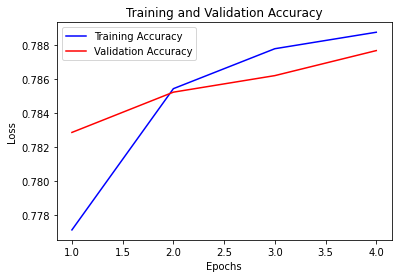

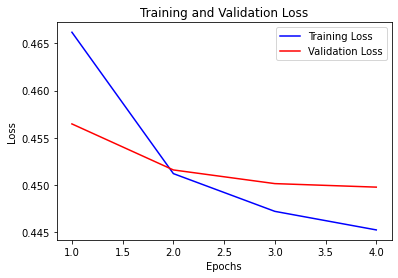

In [33]:
plot_acc_loss(model.history)